# Maciej Buńkowski s28640

## Opis problemu

Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu.
Zbiór może mieć 2 lub 3 klasy.

Następnie:
1. Oczyść dane i zaprezentuj rozkład klas
2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

4. Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.
5. W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla `dwnuk@pjwstk.edu.pl`.

**TERMIN**: 7-Jan-2024

In [1]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import json
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import trange, tqdm
import pandas as pd
import re
import nltk
import numpy as np
from collections import Counter
from gensim.models import KeyedVectors
import accelerate
from transformers import Trainer, TrainingArguments, DistilBertTokenizer, DistilBertForSequenceClassification
import json

#### Preprocessing / import danych

Usuwanie pustych recenzji, zmiana pozycji kolumn, kolejnosci, podzial na klasy, wyrównanie liczności klas

In [2]:
columns_to_import = ['overall_rating', 'review_text']
data_types = {'overall_rating':'int64', 'review_text':'str'}
data = pd.read_csv('B2W-Reviews01.csv', usecols=columns_to_import, dtype=data_types)
data =  data.dropna(subset=['review_text'])
data = data.drop_duplicates()

data['review_text'] = data['review_text'].str.lower()
konwersja = {
    5: 1,
    4: 1,
    3: 1,
    2: 0,
    1: 0
}

data.replace({"overall_rating": konwersja},inplace=True)

### Wyrównanie liczby klas

In [3]:
neg_n = len(data[data['overall_rating']==0])
a=data[data['overall_rating']==1].sample(neg_n)
b=data[data['overall_rating']==0]

data_all = pd.concat([a,b])

data_all.columns = ['rating', 'text']

data_all = data_all[['text', 'rating']]

### Rozkład klas - wyrównany, równa liczba kazdej z klas

([<matplotlib.axis.XTick at 0x283980f40>,
 [Text(0.15, 0, '0'), Text(0.85, 0, '1')])

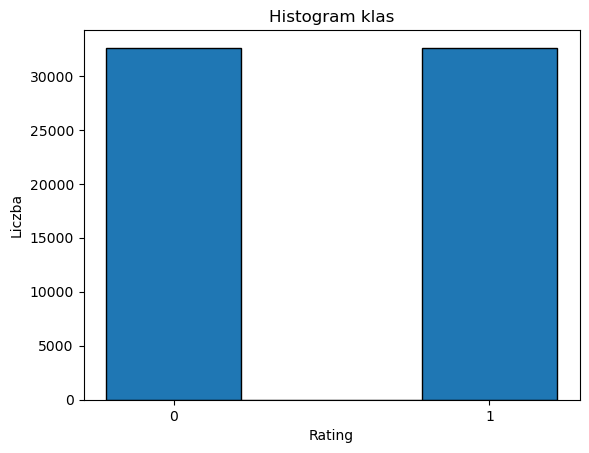

In [4]:
plt.hist(data_all['rating'], bins=[0, 0.3, 0.7, 1], edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Liczba')
plt.title('Histogram klas')
plt.xticks([0.15, 0.85], ['0', '1']) 

Text(0.5, 1.0, 'Histogram długości recenzji (w znakach)')

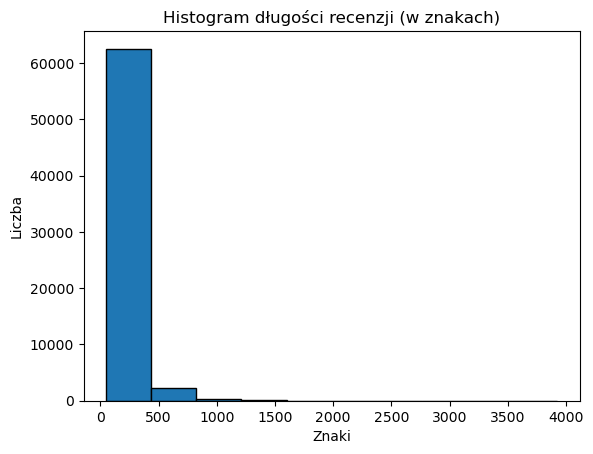

In [5]:
lengths = data_all['text'].str.len()
plt.hist(lengths, edgecolor='black')
plt.xlabel('Znaki')
plt.ylabel('Liczba')
plt.title('Histogram długości recenzji (w znakach)')

### Usunięcie tekstów dłuzszych niz 99 percentyl

In [6]:
percentile_999 = np.percentile(lengths, 99)

data_all = data_all[lengths <= percentile_999]

In [7]:
def check_and_preprocess_string(sentence):
    # Sprawdź czy jest spam (powtarzające sie sekwencje conajmniej kilkukrotnie)
    if re.search(r'(\b[\w\s,.!?;:]{5,}\b)(\1{2,})', sentence):
        return None  # Indicates a spam sentence

    sentence = re.sub(r"[^\w\s]", '', sentence)  
    sentence = re.sub(r"\s+", ' ', sentence)     
    sentence = re.sub(r"\d", '', sentence)
    
    return sentence

In [8]:
data_all['text'] = data_all['text'].apply(check_and_preprocess_string)

In [9]:
data_all = data_all.dropna()

### Podział danych

In [10]:
X,y = data_all['text'].values,data_all['rating'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,stratify=y_train)

print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')
print(f'shape of val data is {x_val.shape}')

shape of train data is (36199,)
shape of test data is (16089,)
shape of val data is (12067,)


### Usunięcie stopwords / lematyzacja / tokenizacja

In [15]:
def tokenize_data(x_train, y_train, x_val, y_val, x_test, y_test):
    stop_words = set(stopwords.words('english')) 
    word_list = []

    for sent in x_train:
            for word in sent.lower().split():
                word = check_and_preprocess_string(word)
                if word not in stop_words and word != '':
                    word_list.append(word)

    corpus = Counter(word_list)
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:10000]

    onehot_dict = {w: i+1 for i, w in enumerate(corpus_)}

    final_list_train, final_list_val, final_list_test = [], [], []
    for sent in x_train:
            final_list_train.append([onehot_dict.get(check_and_preprocess_string(word).lower(), 0) for word in sent.split()])
    for sent in x_val:
            final_list_val.append([onehot_dict.get(check_and_preprocess_string(word).lower(), 0) for word in sent.split()])
    for sent in x_test:
            final_list_test.append([onehot_dict.get(check_and_preprocess_string(word).lower(), 0) for word in sent.split()])


    return final_list_train, y_train, final_list_val, y_val, final_list_test, y_test, onehot_dict

In [16]:
x_train,y_train, x_val, y_val, x_test, y_test,vocab = tokenize_data(x_train,y_train,x_val, y_val, x_test,y_test)

In [19]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 10000


# LSTM

In [20]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [21]:
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)
x_val_pad = padding_(x_val, 500)

In [22]:
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(x_val_pad), torch.from_numpy(y_val))

batch_size = 64

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

In [337]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.3):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        # dropout 
        self.dropout = nn.Dropout(0.3)
    
        # linear  sigmoid 
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x) 
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        sig_out = self.sig(out)
        
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] 
        
        return sig_out, hidden
        
    def init_hidden(self, batch_size):
        hidden = (torch.zeros(self.no_layers, batch_size, self.hidden_dim).to(device),
                  torch.zeros(self.no_layers, batch_size, self.hidden_dim).to(device))
        return hidden

In [349]:
no_layers = 2
vocab_size = len(vocab) + 1
embedding_dim = 64
output_dim = 1
hidden_dim = 256
device = torch.device('mps')

model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)
model.to(device)

SentimentRNN(
  (embedding): Embedding(10001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [339]:
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

# Trening

In [340]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]
batch_size = 64
for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)   
        h = tuple([each.data for each in h])
        model.zero_grad()
        output,h = model(inputs,h)
        
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())

        accuracy = acc(output,labels)
        train_acc += accuracy

        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')

Epoch 1
train_loss : 0.37151033087114316 val_loss : 0.25739430493496834
train_accuracy : 83.82625024162593 val_accuracy : 89.31323005550493
Epoch 2
train_loss : 0.2435364480105649 val_loss : 0.22487496263644796
train_accuracy : 90.39571424626516 val_accuracy : 91.11921133294673
Epoch 3
train_loss : 0.20660915823109383 val_loss : 0.20995108830801984
train_accuracy : 91.92002871896833 val_accuracy : 91.36774086653963
Epoch 4
train_loss : 0.1770352723060456 val_loss : 0.22435466643977672
train_accuracy : 93.16267638693287 val_accuracy : 90.88725043492668
Epoch 5
train_loss : 0.15137031700758807 val_loss : 0.2276352006902403
train_accuracy : 94.37770966227598 val_accuracy : 91.3014663242482


### Test 

In [341]:
total_test_loss = 0
test_acc = 0.0

h = model.init_hidden(batch_size)
model.eval()  

for inputs, labels in test_loader:
    h = tuple([each.data for each in h])

    inputs, labels = inputs.to(device), labels.to(device)
    predictions, h = model(inputs, h)

    loss = criterion(predictions.squeeze(), labels.float())
    total_test_loss += loss.item()

    accuracy = acc(predictions, labels)
    test_acc += accuracy

avg_test_loss = total_test_loss / len(test_loader)
avg_test_acc = test_acc / len(test_loader.dataset)

print(f'Test Loss: {avg_test_loss}, Test Accuracy: {avg_test_acc * 100}%')

Test Loss: 0.24774991070844263, Test Accuracy: 90.77974526250388%


In [351]:
torch.save(model, 'model_LSTM.pth')

In [18]:
vocab_save_path = "/Users/maciejbunkowski/Library/CloudStorage/OneDrive-Polsko-JapońskaAkademiaTechnikKomputerowych/STUDIA/PJATK/III SEMESTR/Zastosowanie Uczenia Maszynowego/P1/vocabulary.json" 

with open(vocab_save_path, 'w') as vocab_file:
    json.dump(vocab, vocab_file)

In [352]:
def predict_text_LSTM(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        output = output.item()
        if output < 0.5:
                return print('This is a negative review')
        else:
                return print('This is a positive review')

In [353]:
predict_text_LSTM('o producto nao e bom, e horrivel')

This is a positive review


In [354]:
predict_text_LSTM(' o televisao e absolutamente incrivel bom.')

This is a negative review


## CNN

In [23]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, filter_sizes, num_filters_per_size):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.convs = nn.ModuleList(
            [nn.Conv1d(in_channels=embedding_dim, 
                       out_channels=num_filters, 
                       kernel_size=f_size) for f_size, num_filters in zip(filter_sizes, num_filters_per_size)]
        )

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(sum(num_filters_per_size), num_classes)

    def forward(self, x):
        x = self.embedding(x)  
        x = x.permute(0, 2, 1)  

        x = [torch.relu(conv(x)) for conv in self.convs]
        x = [torch.max_pool1d(c, c.shape[2]).squeeze(2) for c in x]
        x = torch.cat(x, 1)

        x = self.dropout(x)
        return self.fc(x)

In [24]:
vocab_size = len(vocab)  # Rozmiar słownika
embedding_dim = 256  # Wymiar embeddingów
num_classes =  2  # Liczba klas
filter_sizes = [3, 4, 5]  # Rozmiary filtrów
num_filters = [100, 125, 150]  # Liczba filtrów
device = torch.device('mps')
model = TextCNN(vocab_size, embedding_dim, num_classes, filter_sizes, num_filters)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

TextCNN(
  (embedding): Embedding(10000, 256)
  (convs): ModuleList(
    (0): Conv1d(256, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(256, 125, kernel_size=(4,), stride=(1,))
    (2): Conv1d(256, 150, kernel_size=(5,), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=375, out_features=2, bias=True)
)

In [25]:
def accuracy(output, labels):
    predictions = output.argmax(dim=1, keepdim=True)
    corrects = predictions.eq(labels.view_as(predictions)).sum().item()
    return corrects

In [26]:
clip = 5
epochs = 5
valid_loss_min = np.Inf
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []
batch_size = 64
model.to(device)
for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output = model(inputs)
        
        loss = criterion(output, labels)
        loss.backward()
        train_losses.append(loss.item())

        acc = accuracy(output, labels)
        train_acc += acc

        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_losses = []
    val_acc = 0.0
    model.eval()

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            val_loss = criterion(output, labels)

            val_losses.append(val_loss.item())
            
            acc = accuracy(output, labels)
            val_acc += acc

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    
    print(f'Epoch {epoch+1}') 
    print(f'train_loss: {epoch_train_loss} val_loss: {epoch_val_loss}')
    print(f'train_accuracy: {epoch_train_acc*100:.2f}% val_accuracy: {epoch_val_acc*100:.2f}%')


Epoch 1
train_loss: 0.3485085111012501 val_loss: 0.2543978662566936
train_accuracy: 84.81% val_accuracy: 89.21%
Epoch 2
train_loss: 0.2430750868093651 val_loss: 0.24548097438317665
train_accuracy: 90.32% val_accuracy: 90.39%
Epoch 3
train_loss: 0.19403157666061832 val_loss: 0.23016628541765696
train_accuracy: 92.53% val_accuracy: 91.21%
Epoch 4
train_loss: 0.15762037903861661 val_loss: 0.24502301148753217
train_accuracy: 94.21% val_accuracy: 91.16%
Epoch 5
train_loss: 0.11882600716389385 val_loss: 0.2853447294179746
train_accuracy: 95.70% val_accuracy: 91.02%


In [27]:
def test_model(model, test_loader, criterion, device):
    total_test_loss = 0
    test_acc = 0.0

    model.eval()  

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)

            loss = criterion(predictions, labels)
            total_test_loss += loss.item()

            acc = accuracy(predictions, labels)
            test_acc += acc

    avg_test_loss = total_test_loss / len(test_loader)
    avg_test_acc = test_acc / len(test_loader.dataset)

    print(f'Test Loss: {avg_test_loss}, Test Accuracy: {avg_test_acc * 100}%')

test_model(model, test_loader, criterion, device)

Test Loss: 0.29050867449477374, Test Accuracy: 91.00627758095592%


In [378]:
torch.save(model, 'model_CNN.pth')

In [32]:
torch.save(model.state_dict(),'/Users/maciejbunkowski/Library/CloudStorage/OneDrive-Polsko-JapońskaAkademiaTechnikKomputerowych/STUDIA/PJATK/III SEMESTR/Zastosowanie Uczenia Maszynowego/P1/model.pth')

In [ ]:
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

In [379]:
def predict_text_CNN(text):
   
    word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq,axis=0)
    pad =  torch.from_numpy(padding_(word_seq,500))

    inputs = pad.to(device)
    batch_size=1
    with torch.no_grad():
        output = model(inputs)
        output = output.argmax(dim=1).item()
    if output < 0.5:
                return print('This is a negative review')
    else:
                return print('This is a positive review')

In [380]:
predict_text_CNN("Este é o pior produto que já encontrei e desejo que seu autor morra")

This is a negative review


In [381]:
predict_text_CNN('o televisao e absolutamente incrivel bom.')

This is a positive review


## Pre-train word embeddings

In [382]:
model_word2vec = KeyedVectors.load_word2vec_format('/Users/maciejbunkowski/Library/CloudStorage/OneDrive-Polsko-JapońskaAkademiaTechnikKomputerowych/STUDIA/PJATK/III SEMESTR/Zastosowanie Uczenia Maszynowego/P1/cbow_s100.txt')

In [383]:
def create_embedding_matrix(word2vec_model, word_index, embedding_dim=100):
    """
    : word2vec_model: Pre-trained word2vec model.
    : word_index: Dictionary mapping words to their index in the dataset.
    : embedding_dim: Dimension of the embedding vectors in word2vec model.
    :return: A matrix of shape (len(word_index) + 1, embedding_dim).
    """
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

    for word, i in word_index.items():
        if word in word2vec_model:
            embedding_vector = word2vec_model[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [384]:
embedding_matrix = create_embedding_matrix(model_word2vec, vocab)
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.133973  , -0.186987  , -0.041556  , ..., -0.074089  ,
        -0.15445299,  0.142004  ],
       [-0.14616901, -0.053558  ,  0.015821  , ...,  0.33671901,
        -0.198503  , -0.043026  ],
       ...,
       [-0.098569  ,  0.006254  , -0.31942701, ...,  0.00606   ,
         0.19675   , -0.23822699],
       [-0.011186  ,  0.03489   , -0.101734  , ...,  0.36831599,
         0.237434  ,  0.76385099],
       [ 0.35043401,  0.42430201, -0.21157999, ..., -0.050667  ,
        -0.112264  , -0.232502  ]])

In [403]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, filter_sizes, num_filters_per_size, pretrained_embedding=None):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # pretrained embeddings
        if pretrained_embedding is not None:
            self.embedding.weight = nn.Parameter(torch.tensor(pretrained_embedding, dtype=torch.float32))
            self.embedding.weight.requires_grad = False  # Set embeddings to non-trainable

        self.convs = nn.ModuleList(
            [nn.Conv1d(in_channels=embedding_dim, 
                       out_channels=n_filters, 
                       kernel_size=f_size) for f_size, n_filters in zip(filter_sizes, num_filters_per_size)]
        )

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(sum(num_filters_per_size), num_classes)

    def forward(self, x):
        x = self.embedding(x) 
        x = x.permute(0, 2, 1)  

        x = [torch.relu(conv(x)) for conv in self.convs]
        x = [torch.max_pool1d(c, c.shape[2]).squeeze(2) for c in x]
        x = torch.cat(x, 1)

        x = self.dropout(x)
        return self.fc(x)


In [404]:
vocab_size = len(vocab)  # Rozmiar słownika
embedding_dim = 100  # Wymiar embeddingów
num_classes =  2  # Liczba klas
filter_sizes = [3, 4, 5]  # Rozmiary filtrów
num_filters = [100,150,200]  # Liczba filtrów
model = TextCNN(vocab_size, embedding_dim, num_classes, filter_sizes, num_filters,pretrained_embedding=embedding_matrix)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

TextCNN(
  (embedding): Embedding(10000, 100)
  (convs): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(100, 150, kernel_size=(4,), stride=(1,))
    (2): Conv1d(100, 200, kernel_size=(5,), stride=(1,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=450, out_features=2, bias=True)
)

In [405]:
clip = 5
epochs = 5
valid_loss_min = np.Inf
epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []
batch_size = 64
model.to(device)
for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output = model(inputs)
        
        loss = criterion(output, labels)
        loss.backward()
        train_losses.append(loss.item())

        acc = accuracy(output, labels)
        train_acc += acc

        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    val_losses = []
    val_acc = 0.0
    model.eval()

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            val_loss = criterion(output, labels)

            val_losses.append(val_loss.item())
            
            acc = accuracy(output, labels)
            val_acc += acc

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    
    print(f'Epoch {epoch+1}') 
    print(f'train_loss: {epoch_train_loss} val_loss: {epoch_val_loss}')
    print(f'train_accuracy: {epoch_train_acc*100:.2f}% val_accuracy: {epoch_val_acc*100:.2f}%')

    # Sprawdź, czy należy aktualizować minimum straty walidacji
    if epoch_val_loss < valid_loss_min:
        valid_loss_min = epoch_val_loss

Epoch 1
train_loss: 0.37900940673013706 val_loss: 0.30825173426815805
train_accuracy: 83.05% val_accuracy: 86.64%
Epoch 2
train_loss: 0.2895568613457469 val_loss: 0.2800617147474847
train_accuracy: 87.85% val_accuracy: 88.33%
Epoch 3
train_loss: 0.2527901414485104 val_loss: 0.2718925817691265
train_accuracy: 89.76% val_accuracy: 88.59%
Epoch 4
train_loss: 0.22647462633595003 val_loss: 0.27628909816291736
train_accuracy: 90.76% val_accuracy: 88.80%
Epoch 5
train_loss: 0.19656257104557173 val_loss: 0.2609425454222141
train_accuracy: 92.25% val_accuracy: 89.25%


In [80]:
def test_model(model, test_loader, criterion, device):
    total_test_loss = 0
    test_acc = 0.0

    model.eval()  

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            predictions = model(inputs)

            loss = criterion(predictions, labels)
            total_test_loss += loss.item()

            acc = accuracy(predictions, labels)
            test_acc += acc

    avg_test_loss = total_test_loss / len(test_loader)
    avg_test_acc = test_acc / len(test_loader.dataset)

    print(f'Test Loss: {avg_test_loss}, Test Accuracy: {avg_test_acc * 100}%')

test_model(model, test_loader, criterion, device)

Test Loss: 0.27334474142007675, Test Accuracy: 89.43922924901186%


In [81]:
def predict_text_CNN_with_embedding(text):
    # Przetwarzanie tekstu na sekwencję identyfikatorów słów
    word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq,axis=0)
    pad =  torch.from_numpy(padding_(word_seq,500))
    inputs = pad.to(device)
    batch_size=1
    with torch.no_grad():
        output = model(inputs)
        output = output.argmax(dim=1).item()
    if output < 0.5:
                return print('This is a negative review')
    else:
                return print('This is a positive review')

In [84]:
predict_text_CNN_with_embedding("Fiquei completamente decepcionado com esta compra. O produto chegou danificado e o atendimento ao cliente foi terrível")

This is a negative review


In [85]:
predict_text_CNN_with_embedding('Excelente compra! O produto é exatamente como descrito e funciona perfeitamente. Vou comprar novamente sem dúvida.')

This is a positive review


### DistilBERT

In [15]:
reviews = data_all['text'].tolist()
rating = data_all['rating'].tolist()

In [18]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(data_all['text'], data_all['rating'], test_size=0.3)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5)

In [37]:
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True,max_length=500, return_tensors="pt")
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=500, return_tensors="pt")
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=500, return_tensors="pt")

In [45]:
train_labels = train_labels.to_list()
test_labels = test_labels.to_list()
val_labels = val_labels.to_list()

In [46]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

In [47]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_dir='./logs',
    evaluation_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


In [48]:
trainer.train()

  0%|          | 0/8448 [00:00<?, ?it/s]

<ipython-input-46-ace5fd3938dd>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.3284, 'learning_rate': 4.70407196969697e-05, 'epoch': 0.18}


<ipython-input-46-ace5fd3938dd>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.2427, 'learning_rate': 4.408143939393939e-05, 'epoch': 0.36}


<ipython-input-46-ace5fd3938dd>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.254, 'learning_rate': 4.112215909090909e-05, 'epoch': 0.53}


<ipython-input-46-ace5fd3938dd>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.2217, 'learning_rate': 3.816287878787879e-05, 'epoch': 0.71}


<ipython-input-46-ace5fd3938dd>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.2187, 'learning_rate': 3.520359848484849e-05, 'epoch': 0.89}


<ipython-input-46-ace5fd3938dd>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/151 [00:00<?, ?it/s]

{'eval_loss': 0.24215343594551086, 'eval_runtime': 83.934, 'eval_samples_per_second': 115.019, 'eval_steps_per_second': 1.799, 'epoch': 1.0}
{'loss': 0.1906, 'learning_rate': 3.2244318181818185e-05, 'epoch': 1.07}


<ipython-input-46-ace5fd3938dd>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.1819, 'learning_rate': 2.928503787878788e-05, 'epoch': 1.24}


<ipython-input-46-ace5fd3938dd>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.1702, 'learning_rate': 2.6325757575757575e-05, 'epoch': 1.42}


<ipython-input-46-ace5fd3938dd>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.1705, 'learning_rate': 2.3366477272727273e-05, 'epoch': 1.6}


<ipython-input-46-ace5fd3938dd>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.1614, 'learning_rate': 2.040719696969697e-05, 'epoch': 1.78}


<ipython-input-46-ace5fd3938dd>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.1755, 'learning_rate': 1.7447916666666666e-05, 'epoch': 1.95}


<ipython-input-46-ace5fd3938dd>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/151 [00:00<?, ?it/s]

{'eval_loss': 0.19077080488204956, 'eval_runtime': 85.9464, 'eval_samples_per_second': 112.326, 'eval_steps_per_second': 1.757, 'epoch': 2.0}
{'loss': 0.1357, 'learning_rate': 1.4488636363636366e-05, 'epoch': 2.13}


<ipython-input-46-ace5fd3938dd>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.1147, 'learning_rate': 1.1529356060606061e-05, 'epoch': 2.31}


<ipython-input-46-ace5fd3938dd>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.1151, 'learning_rate': 8.570075757575757e-06, 'epoch': 2.49}


<ipython-input-46-ace5fd3938dd>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.1142, 'learning_rate': 5.610795454545455e-06, 'epoch': 2.66}


<ipython-input-46-ace5fd3938dd>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'loss': 0.1244, 'learning_rate': 2.651515151515152e-06, 'epoch': 2.84}


<ipython-input-46-ace5fd3938dd>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/151 [00:00<?, ?it/s]

{'eval_loss': 0.24217675626277924, 'eval_runtime': 83.821, 'eval_samples_per_second': 115.174, 'eval_steps_per_second': 1.801, 'epoch': 3.0}
{'train_runtime': 4556.4447, 'train_samples_per_second': 29.664, 'train_steps_per_second': 1.854, 'train_loss': 0.1788234728755373, 'epoch': 3.0}


TrainOutput(global_step=8448, training_loss=0.1788234728755373, metrics={'train_runtime': 4556.4447, 'train_samples_per_second': 29.664, 'train_steps_per_second': 1.854, 'train_loss': 0.1788234728755373, 'epoch': 3.0})

In [49]:
trainer.evaluate(test_dataset)

<ipython-input-46-ace5fd3938dd>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/151 [00:00<?, ?it/s]

{'eval_loss': 0.257758766412735,
 'eval_runtime': 67.0094,
 'eval_samples_per_second': 144.084,
 'eval_steps_per_second': 2.253,
 'epoch': 3.0}

In [56]:
model.save_pretrained('/Users/maciejbunkowski/Library/CloudStorage/OneDrive-Polsko-JapońskaAkademiaTechnikKomputerowych/STUDIA/PJATK/III SEMESTR/Zastosowanie Uczenia Maszynowego/P1')
tokenizer.save_pretrained('/Users/maciejbunkowski/Library/CloudStorage/OneDrive-Polsko-JapońskaAkademiaTechnikKomputerowych/STUDIA/PJATK/III SEMESTR/Zastosowanie Uczenia Maszynowego/P1')

('/Users/maciejbunkowski/Library/CloudStorage/OneDrive-Polsko-JapońskaAkademiaTechnikKomputerowych/STUDIA/PJATK/III SEMESTR/Zastosowanie Uczenia Maszynowego/P1/tokenizer_config.json',
 '/Users/maciejbunkowski/Library/CloudStorage/OneDrive-Polsko-JapońskaAkademiaTechnikKomputerowych/STUDIA/PJATK/III SEMESTR/Zastosowanie Uczenia Maszynowego/P1/special_tokens_map.json',
 '/Users/maciejbunkowski/Library/CloudStorage/OneDrive-Polsko-JapońskaAkademiaTechnikKomputerowych/STUDIA/PJATK/III SEMESTR/Zastosowanie Uczenia Maszynowego/P1/vocab.txt',
 '/Users/maciejbunkowski/Library/CloudStorage/OneDrive-Polsko-JapońskaAkademiaTechnikKomputerowych/STUDIA/PJATK/III SEMESTR/Zastosowanie Uczenia Maszynowego/P1/added_tokens.json')

In [61]:
def predict_text_distilbert(text, model, tokenizer, device='cpu'):
    # Tokenize the input text and prepare input tensors
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}  # Move inputs to the correct device

    # Model inference
    model.to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)

    # Interpret the output
    if predictions.item() == 1:
        return 'This is a positive review'
    else:
        return 'This is a negative review'


In [65]:
predict_text_distilbert('Adorei a câmera que comprei online! A qualidade da imagem é incrível e a entrega foi super rápida. Funciona perfeitamente e superou minhas expectativas.', model, tokenizer)

'This is a positive review'

In [66]:
predict_text_distilbert('Não estou satisfeito com o smartphone que comprei. Chegou atrasado e a bateria dura muito pouco. Além disso, o aparelho trava frequentemente. Não recomendo',  model, tokenizer)

'This is a negative review'